In [101]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm_notebook
from scipy.sparse import csr_matrix, hstack

from sklearn.metrics import f1_score, hamming_loss, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, train_test_split

import gensim
import pymorphy2


import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [102]:
df_train = pd.read_csv('../Data/topics_data/train.tsv', sep='\t', encoding='utf-8', lineterminator='\n', 
                       names=['Index', 'Title', 'Text', 'targets'])

df_test = pd.read_csv('../Data/topics_data/test.tsv', sep='\t', encoding='utf-8', lineterminator='\n', 
                       names=['Index', 'Title', 'Text'])

In [103]:
df_train.head()

,Index,Title,Text,targets
0,0,Краткая история российско-американских отношен...,Когда «Лишь бы не было войны» сменилось мемом ...,"2,7,10,29,50"
1,1,Видео: Квартира среднестатистического китайца,"Практически все уже знают, что Китай - произв...","79,95"
2,2,Дни Украины сочтены!,"Не смотря на столь громкий заголовок я, до ...","2,10,71"
3,3,Плюсы и минусы жизни на Мальте,"Доброго времени суток дорогие читатели, сегод...",15
4,4,В СССР все были неравны,На фоне громких расследований Фонда по Борьбе ...,3


### Delete texts with missing targets

In [104]:
initshape = df_train.shape[0]
df_train = df_train[~df_train['targets'].isna()]
print(f'{initshape - df_train.shape[0]} Rows were deleted')

df_train['Text'].fillna('Notext', inplace=True)
df_test['Text'].fillna('Notext', inplace=True)


5 Rows were deleted


### Tags preprocessing

In [105]:
def transflabels(x):
    x = [int(i) for i in x.split(',')]
    return x

In [106]:
df_train['targets'] = df_train['targets'].apply(transflabels)

In [107]:
df_train.head()

,Index,Title,Text,targets
0,0,Краткая история российско-американских отношен...,Когда «Лишь бы не было войны» сменилось мемом ...,"[2, 7, 10, 29, 50]"
1,1,Видео: Квартира среднестатистического китайца,"Практически все уже знают, что Китай - произв...","[79, 95]"
2,2,Дни Украины сочтены!,"Не смотря на столь громкий заголовок я, до ...","[2, 10, 71]"
3,3,Плюсы и минусы жизни на Мальте,"Доброго времени суток дорогие читатели, сегод...",[15]
4,4,В СССР все были неравны,На фоне громких расследований Фонда по Борьбе ...,[3]


In [108]:
mlb = MultiLabelBinarizer()
mlb.fit(df_train['targets'])
Y = mlb.transform(df_train['targets'])

In [109]:
Y.shape

(126020, 100)

### Tags alalisys

In [110]:
df_tags = pd.DataFrame(Y, columns=range(0, 100))

In [111]:
df_tags.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Target destribution is a quite strange. A good idea is to use sampling technics. I expected to see the same destribution for a test set.

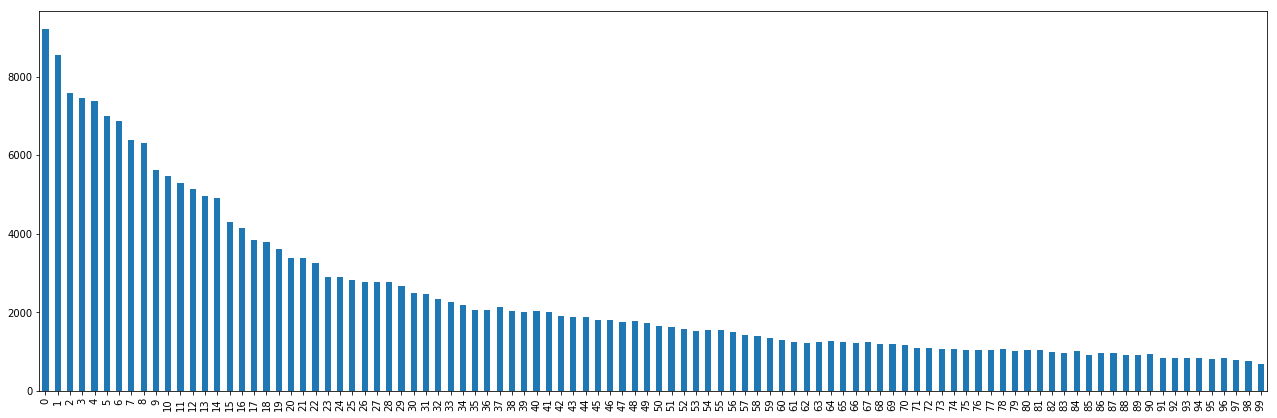

In [112]:
plt.figure(figsize=(22, 7))
df_tags.sum(axis=0).plot(kind='bar')

In [113]:
# Стоп слова для TF-IDF
stop_words_list = []
with open('OtherFiles/stopword_rus.txt') as F:
    for line in F:
        stop_words_list.append(F.readline().rstrip())


### Gensim

In [114]:

# model = gensim.models.KeyedVectors.load_word2vec_format("OtherFiles/ruwikiruscorpora_0_300_20.bin.gz", binary=True)
# model.init_sims(replace=True)

# morph = pymorphy2.MorphAnalyzer()

### TfidVectorizer

In [115]:
tfidf_title = TfidfVectorizer(ngram_range=(1, 3), max_features=40000, stop_words=stop_words_list)
X_idf_title = tfidf_title.fit_transform(df_train['Title'])
X_idf_title_test = tfidf_title.transform(df_test['Title'])
print('Titles transformed!')

Titles transformed!


In [116]:
tfidf_text = TfidfVectorizer(ngram_range=(1, 2), max_features=130000, stop_words=stop_words_list)
X_idf_text = tfidf_text.fit_transform(df_train['Text'])
X_idf_text_test = tfidf_text.transform(df_test['Text'])
print('Texts transformed!')

Texts transformed!


In [70]:
# # Store tf-idf results to the pickle format to save time
# with open('OtherFiles/tfidf_title_30K', 'wb') as F:
#     pickle.dump(tfidf_title, F)
# with open('OtherFiles/X_idf_title_30K', 'wb') as F:
#     pickle.dump(X_idf_title, F)
# with open('OtherFiles/X_idf_title_test_30K', 'wb') as F:
#     pickle.dump(X_idf_title_test, F)
    
# with open('OtherFiles/tfidf_text_70K', 'wb') as F:
#     pickle.dump(tfidf_text, F)
# with open('OtherFiles/X_idf_text_70K', 'wb') as F:
#     pickle.dump(X_idf_text, F)
# with open('OtherFiles/X_idf_text_test_70K', 'wb') as F:
#     pickle.dump(X_idf_text_test, F)

In [71]:
# # Store tf-idf results to the pickle format to save time
# with open('OtherFiles/tfidf_title_30K', 'rb') as F:
#     tfidf_title = pickle.load(F)
# with open('OtherFiles/X_idf_title_30K', 'rb') as F:
#     X_idf_title = pickle.load(F)
# with open('OtherFiles/X_idf_title_test_30K', 'rb') as F:
#     X_idf_title_test = pickle.load(F)
    
# with open('OtherFiles/tfidf_text_70K', 'rb') as F:
#     tfidf_text = pickle.load(F)
# with open('OtherFiles/X_idf_text_70K', 'rb') as F:
#     X_idf_text = pickle.load(F)
# with open('OtherFiles/X_idf_text_test_70K', 'rb') as F:
#     X_idf_text_test = pickle.load(F)

### Stack features and sparse matrixes

In [117]:
X_conc_train = csr_matrix(hstack([X_idf_title, X_idf_text]))
X_conc_test = csr_matrix(hstack([X_idf_title_test, X_idf_text_test]))

### Metric calculation

In [118]:
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
X_train, X_val, Y_train, Y_val = train_test_split(X_conc_train, Y, test_size=0.25)

### ML models

In [119]:
def gettagsdist(Tags):
    """
    A function that plots tags destribution
    """
    df_tags = pd.DataFrame(Tags, columns=range(0, 100))
    plt.figure(figsize=(22, 7))
    df_tags.sum(axis=0).plot(kind='bar')

In [120]:
def fthreshold(x, th):
    return 1 if x > th else 0

fthreshold = np.vectorize(fthreshold)

In [121]:
model = LogisticRegression(C=2, penalty='l2')
clf = OneVsRestClassifier(model, n_jobs=-1)
clf.fit(X_train, Y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=2, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=-1)

In [122]:
preds = clf.predict_proba(X_val)

In [130]:
f1_score(Y_val, fthreshold(preds, th=0.12), average='samples')

0.5373059539342668

Text(0.5, 1.0, 'Destribution of validation dataset')

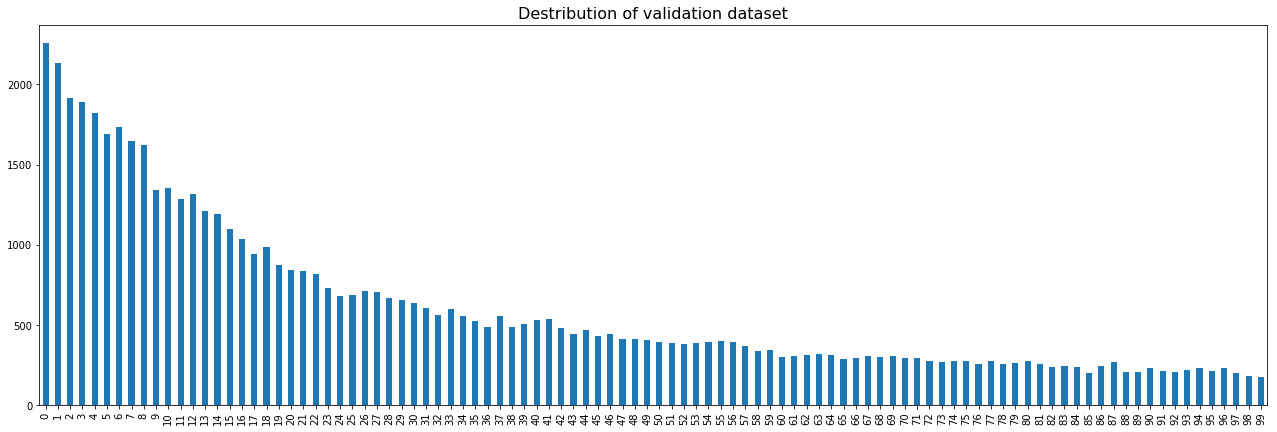

In [125]:
gettagsdist(Y_val)
plt.title('Destribution of validation dataset', size=16)

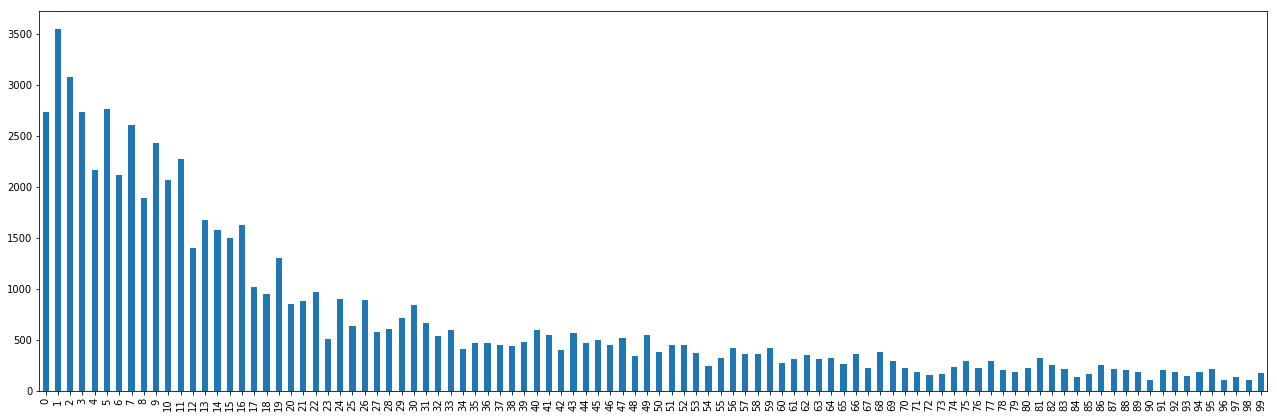

In [126]:
gettagsdist(fthreshold(preds, 0.12))

In [219]:
class SuperThreshold():
    def __init__(self):
        self.th_list = []
        
        
    def fit_transform(self, Y_val, preds, start_thres=0.2, alpha=0.01):
        for i in range(100):
#             print(i)
            thres_i = start_thres  # alpha для класса i
            alpha_i = alpha
            
            y_val = Y_val[:, i].sum()
            pred_i = preds[:, i]
            pred_binary = fthreshold(pred_i, start_thres)
#             print(np.sum(pred_binary), y_val)
            cond = np.sum(pred_binary) < y_val
#             print(cond)
            
            if cond:  # Если элементов недостаточно, уменьшаем порог на alpha
                alpha_i *= -1
                
            while 1:
                thres_i += alpha_i
                pred_binary = fthreshold(pred_i, thres_i)
#                 print(np.sum(pred_binary), y_val, thres_i)
                if (np.sum(pred_binary) < y_val) != cond: 
                    self.th_list.append(thres_i)  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                    break
        self.transform(preds)
    
    
    def transform(self, preds):
        for i in range(100):
            try:
                preds[:, i] = fthreshold(preds[:, i], self.th_list[i])
            except:
                print(i)
        return preds
                    
                


In [220]:
sth = SuperThreshold()

In [221]:
sth.fit_transform(Y_val, preds)

In [222]:
preds

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

In [225]:
f1_score(Y_val, preds, average='samples')

0.5276802435428051

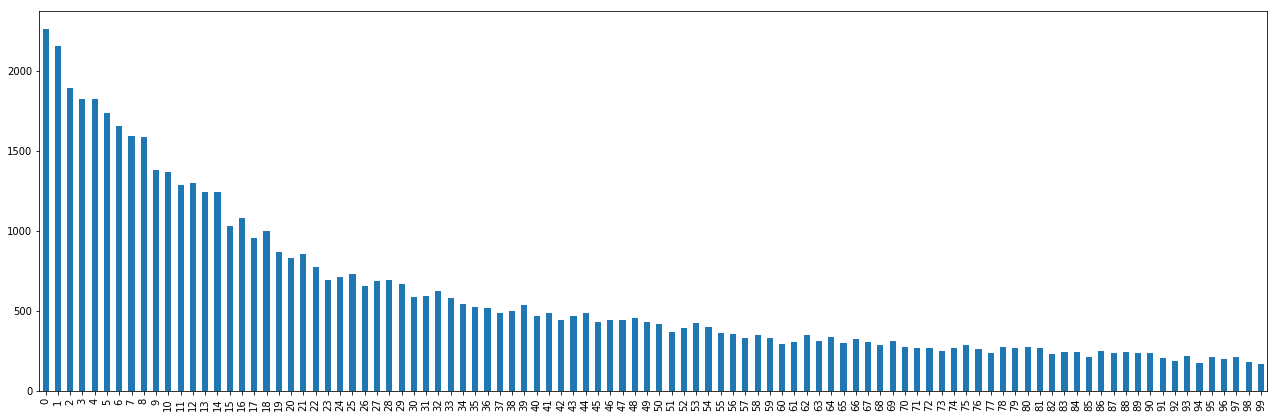

In [224]:
gettagsdist(preds)

### Analizing model errors

In [81]:
rez = []
for i in tqdm_notebook(range(100)):
    y_train_i = Y_train[:, i]
    y_val_i = Y_val[:, i]
    model_tmp = LogisticRegression(C=5, n_jobs=7)
    model_tmp.fit(X_train, y_train_i)
    pr = model_tmp.predict(X_val)
    rez.append(accuracy_score(y_val_i, pr))


KeyboardInterrupt: 

### SVC

In [ ]:
svc_model = SVC(C=1)
svc_model.fit(X_train, Y_train[:, 0])
clf_svc = OneVsRestClassifier(svc_model, n_jobs=-1)
clf_svc.fit(X_train, Y_train)

/root/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
preds = clf_svc.predict_proba(X_val)

In [ ]:
f1_score(Y_val, fthreshold(preds, th=0.15), average='samples')

In [ ]:
gettagsdist(Y_val)
plt.title('Destribution of validation dataset', size=16)

In [ ]:
gettagsdist(fthreshold(preds, 0.15))

In [ ]:
svc_model = SVC(C=0.01, n_jobs=6)
svc_model.fit(X_train, Y_train[:, 0])

### Use model on the given test data

In [131]:
def correctpredicts(predicts, pred_max):
    """
    If all of predictions are lower than threshold, get most likelihood label
    """
    for line in range(len(predicts)):
        x = ','.join([str(i) for i in list(predicts[line])])
        if len(x) == 0:
            x = str(pred_max[line])
        predicts[line] = x
    return predicts

Train the model on the full dataset

In [ ]:
clf.fit(X_conc_train, Y)

In [ ]:
pred = clf.predict_proba(X_conc_test)
pred_max = np.argmax(pred, axis=1)
pred = fthreshold(pred, 0.12)

In [ ]:
# pred = sth.transform(pred)

In [ ]:
pred = mlb.inverse_transform(pred)

In [ ]:
pred = correctpredicts(pred, pred_max)

In [ ]:
def submissionfile(predicts, submit_name):
    with open('../Submissions/'+submit_name+'.csv', 'w') as f:
        for ind, val in zip(df_test['Index'].values, predicts):
            f.write(str(ind))
            f.write('\t')
            f.write(val)
            f.write('\n')
#     df = pd.DataFrame({'Index': df_test['Index'].values, 'Predicts': predicts})
#     df.to_csv('../Submissions/'+submit_name+'.csv', header=False, index=False)    

In [100]:
submissionfile(pred, 'Submit_16_C=2_012_0.53730')